# Where do we go?

This notebook is meant to find an answer to this problem.

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from inversion.individual import FatalityIndividualModel
from inversion.population.models import FatalityPopulationModel
from outbreak.plot import plot_outbreak
from utils.regions import OECD

%reload_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize']=[32,18]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

plt.style.use('seaborn-whitegrid')


In [157]:
from epydemic.outbreak import Outbreak, OutbreakTimeWindow, Epidemic
from epydemic.utils.helpers import build_coronavirus_epidemic
from epydemic.inversion.individual import FatalityIndividualModel
from epydemic.inversion.population.models import FatalityPopulationModel
from epydemic.utils.path import DATA_ROOTPATH

## Oxford Data

In [158]:
raw_oxford_df = pd.read_csv(DATA_ROOTPATH / "raw/oxford_data.csv", parse_dates=["Date"])

In [159]:
oxford_df = raw_oxford_df.drop(columns=["CountryCode"]).replace({"United States": "US", "Czech Republic": "Czechia"})\
         .pivot(index="Date", columns="CountryName")\
         .fillna(method="ffill")

oxford_df.columns = oxford_df.columns.set_levels(
    oxford_df.columns.levels[0].str.replace(" ", "_"), 
    level=0
)

In [175]:
policies: pd.Index = oxford_df.columns.unique(0)

index_policies = policies[policies.str.contains("Index")]

individual_policies = policies[~(policies.str.contains("Index") | policies.str.contains("Confirmed"))]

def clean_policy(policy: str):
    return policy.replace(" ", "_").replace("/", "_")

individual_policy_dict = {
    clean_policy(policy): oxford_df[policy] for policy in individual_policies
}

list(individual_policy_dict.keys())

['C1_School_closing',
 'C1_Flag',
 'C2_Workplace_closing',
 'C2_Flag',
 'C3_Cancel_public_events',
 'C3_Flag',
 'C4_Restrictions_on_gatherings',
 'C4_Flag',
 'C5_Close_public_transport',
 'C5_Flag',
 'C6_Stay_at_home_requirements',
 'C6_Flag',
 'C7_Restrictions_on_internal_movement',
 'C7_Flag',
 'C8_International_travel_controls',
 'E1_Income_support',
 'E1_Flag',
 'E2_Debt_contract_relief',
 'E3_Fiscal_measures',
 'E4_International_support',
 'H1_Public_information_campaigns',
 'H1_Flag',
 'H2_Testing_policy',
 'H3_Contact_tracing',
 'H4_Emergency_investment_in_healthcare',
 'H5_Investment_in_vaccines',
 'M1_Wildcard']

In [176]:
epidemic = build_coronavirus_epidemic(**individual_policy_dict)

for region, outbreak in epidemic.outbreaks.items():
    outbreak.to_csv()

### Health Policies

In [177]:
health_policies = individual_policies[individual_policies.str.contains("H\d", regex=True)]

In [178]:
df = pd.read_csv(DATA_ROOTPATH / "oecd_outbreak_record.csv", index_col=[1, 2, 3])

In [179]:
def build_otw_policies(otw : OutbreakTimeWindow):
    result = {}

    for policy in health_policies:
        outbreak_policy = otw[policy]

        # pick most recent policy at time of consideration
        result[policy] = outbreak_policy.iloc[-1]

    return result


In [180]:
for region, outbreak in epidemic.get_outbreaks(OECD).items():
    if region not in df.index.unique(level=0):
        print(region, "not in df")
        continue
        
    for otw in outbreak.expanding_windows():
        row = df.loc[(region, otw.start, otw.end)]

        for policy in policies:
            df.loc[(region, otw.start, otw.end), policy] = otw[policy].iloc[-1]


Australia not in df
Austria not in df


KeyError: 'E2_Debt/contract_relief'

## Regression

In [172]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X = df[health_policies].reset_index(drop=True).fillna(0).values
y = df["MTTF"].reset_index(drop=True).values

### Clean Features

In [173]:
inf_mask = np.isinf(y)

X = X[~inf_mask]
y = y[~inf_mask]

X.shape, y.shape

((187, 6), (187,))

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [169]:
reg = RandomForestRegressor()

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("R2", r2_score(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))

R2 -3.932241521693591e+88
MAE 3.113262008421119e+67


In [170]:
df.iloc[X["H1_Flag"].isna().argmax()]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [119]:
y_test

84      4.363037
18     10.084282
133    14.624202
12     17.837509
169    83.053155
149    11.694430
159     4.411141
108     6.188831
39     35.488655
185     0.279397
173     0.098029
36      8.486504
27      2.874392
13     21.259088
7       4.843318
74      2.181491
14     17.837509
118     8.662784
128    24.637697
24      0.805546
120    45.153010
122     9.202877
153     2.591679
158     4.547513
147    11.740428
20     11.042974
101     0.589478
129    27.474765
176    12.836350
104    14.935605
134     0.009255
165    42.392925
150     9.264733
62     62.443427
142    12.507980
102     0.159082
111     0.051966
179     4.038710
160     0.168159
15     31.138869
96     29.717830
70     18.655019
9       1.502887
58     10.832539
95      0.252137
174     0.254366
28     40.140547
Name: MTTF, dtype: float64

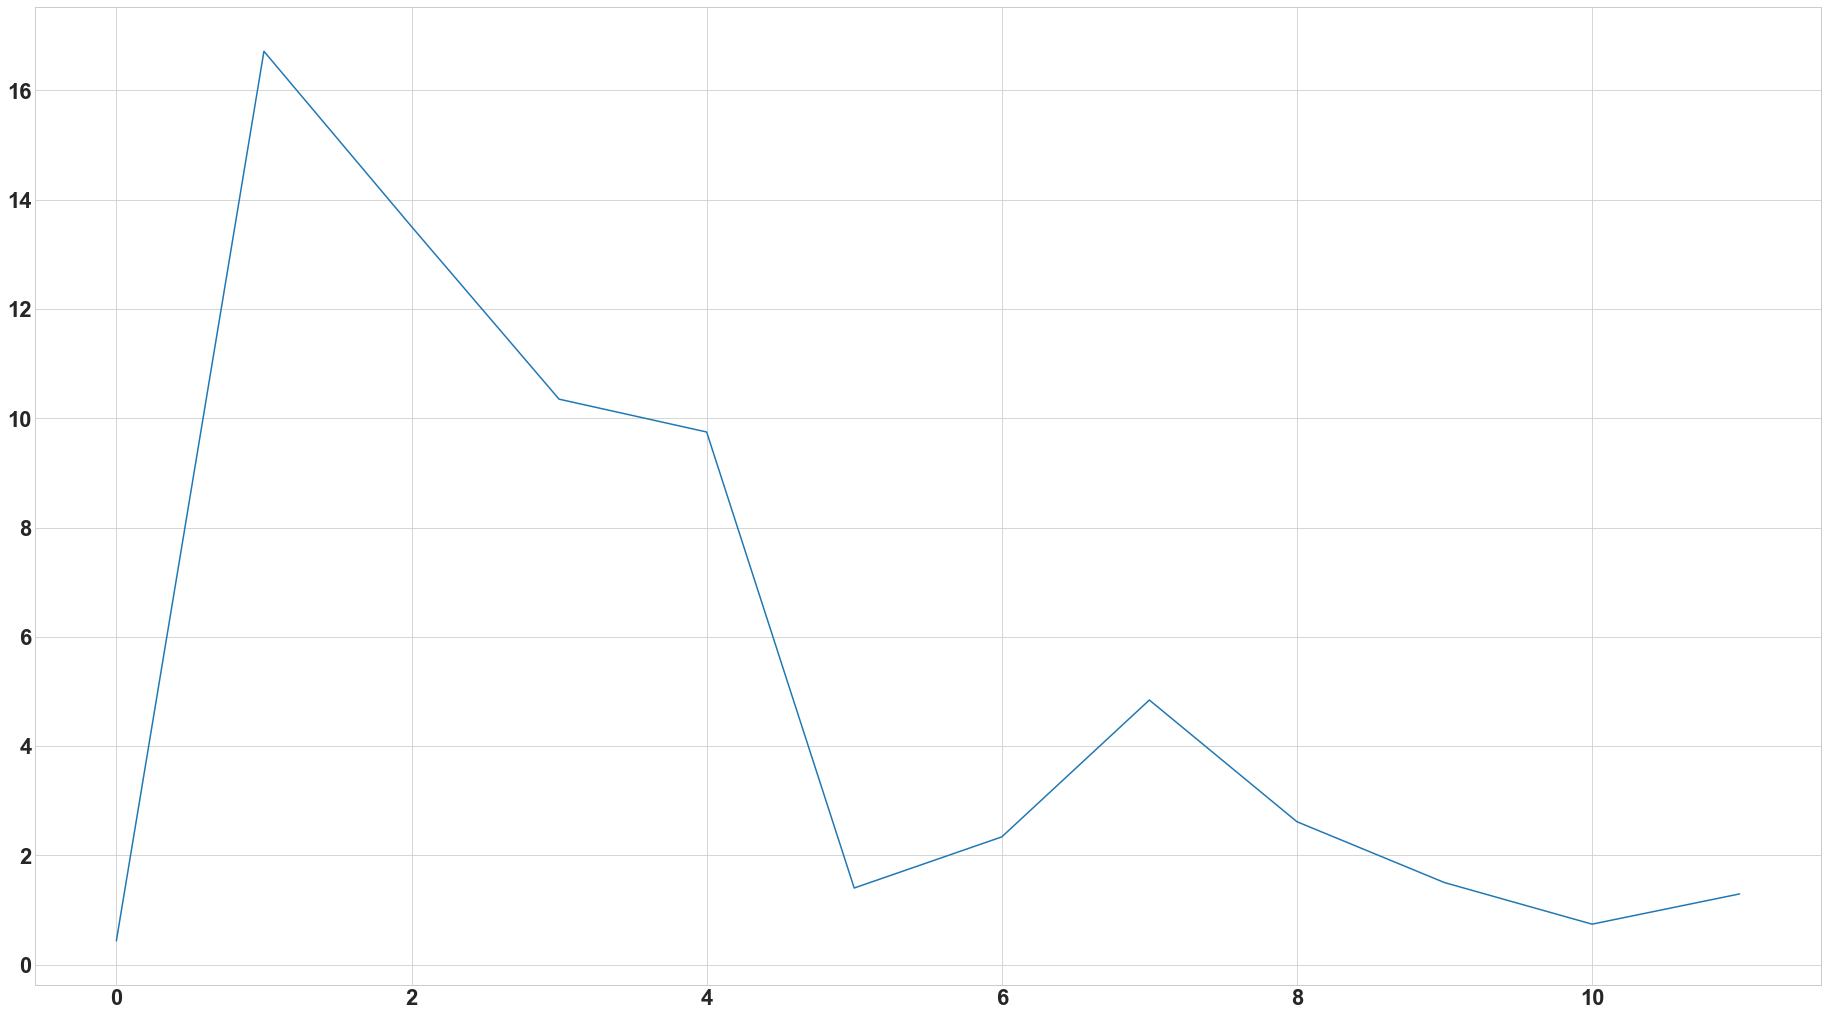

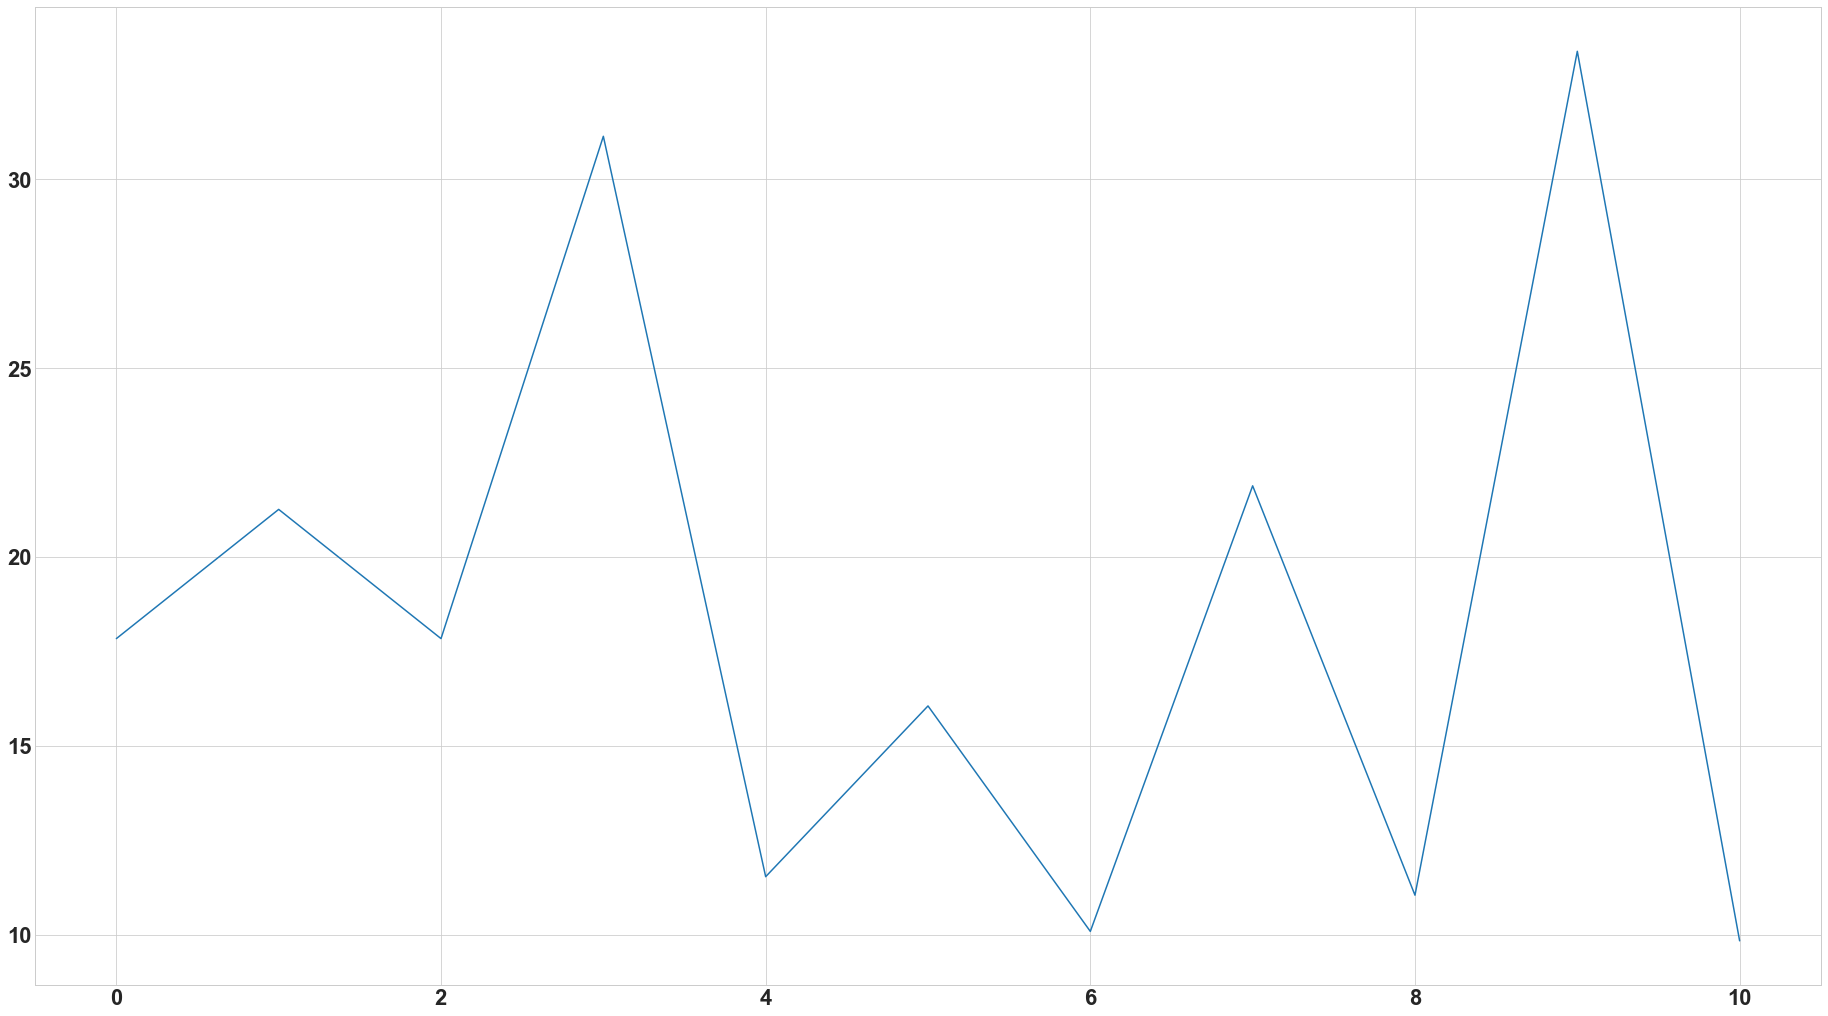

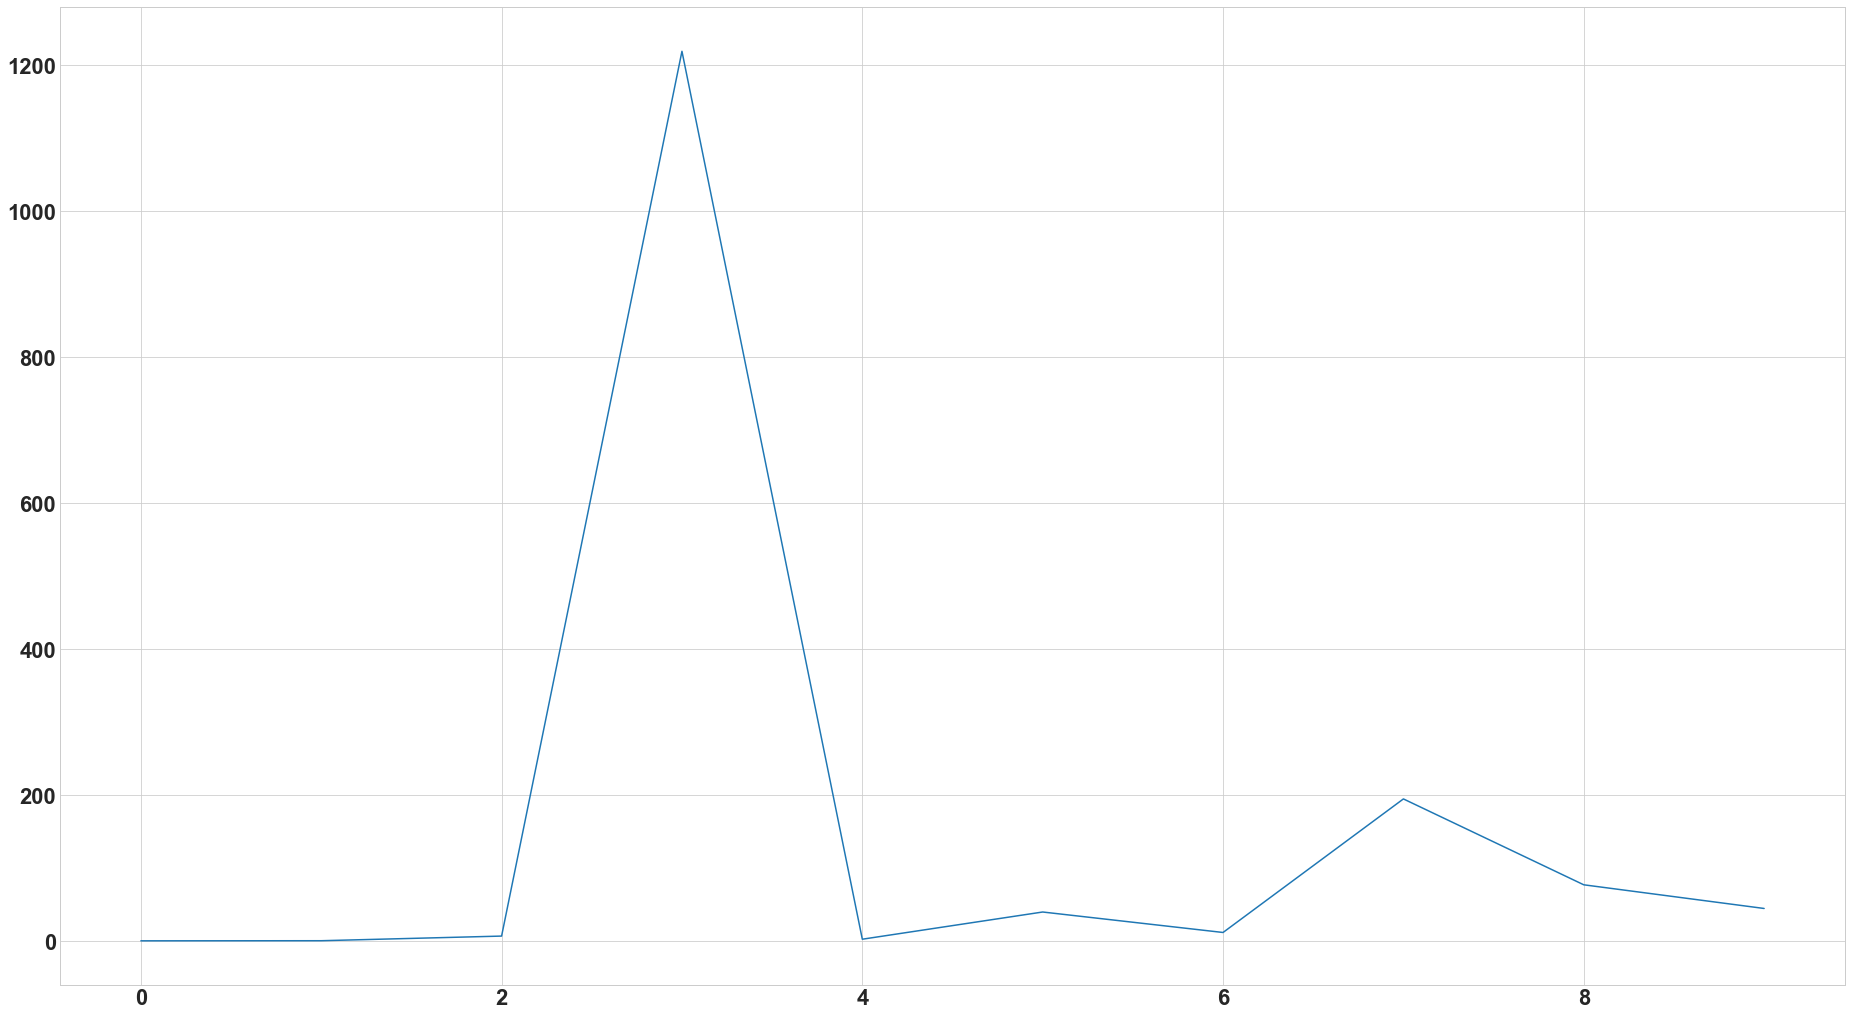

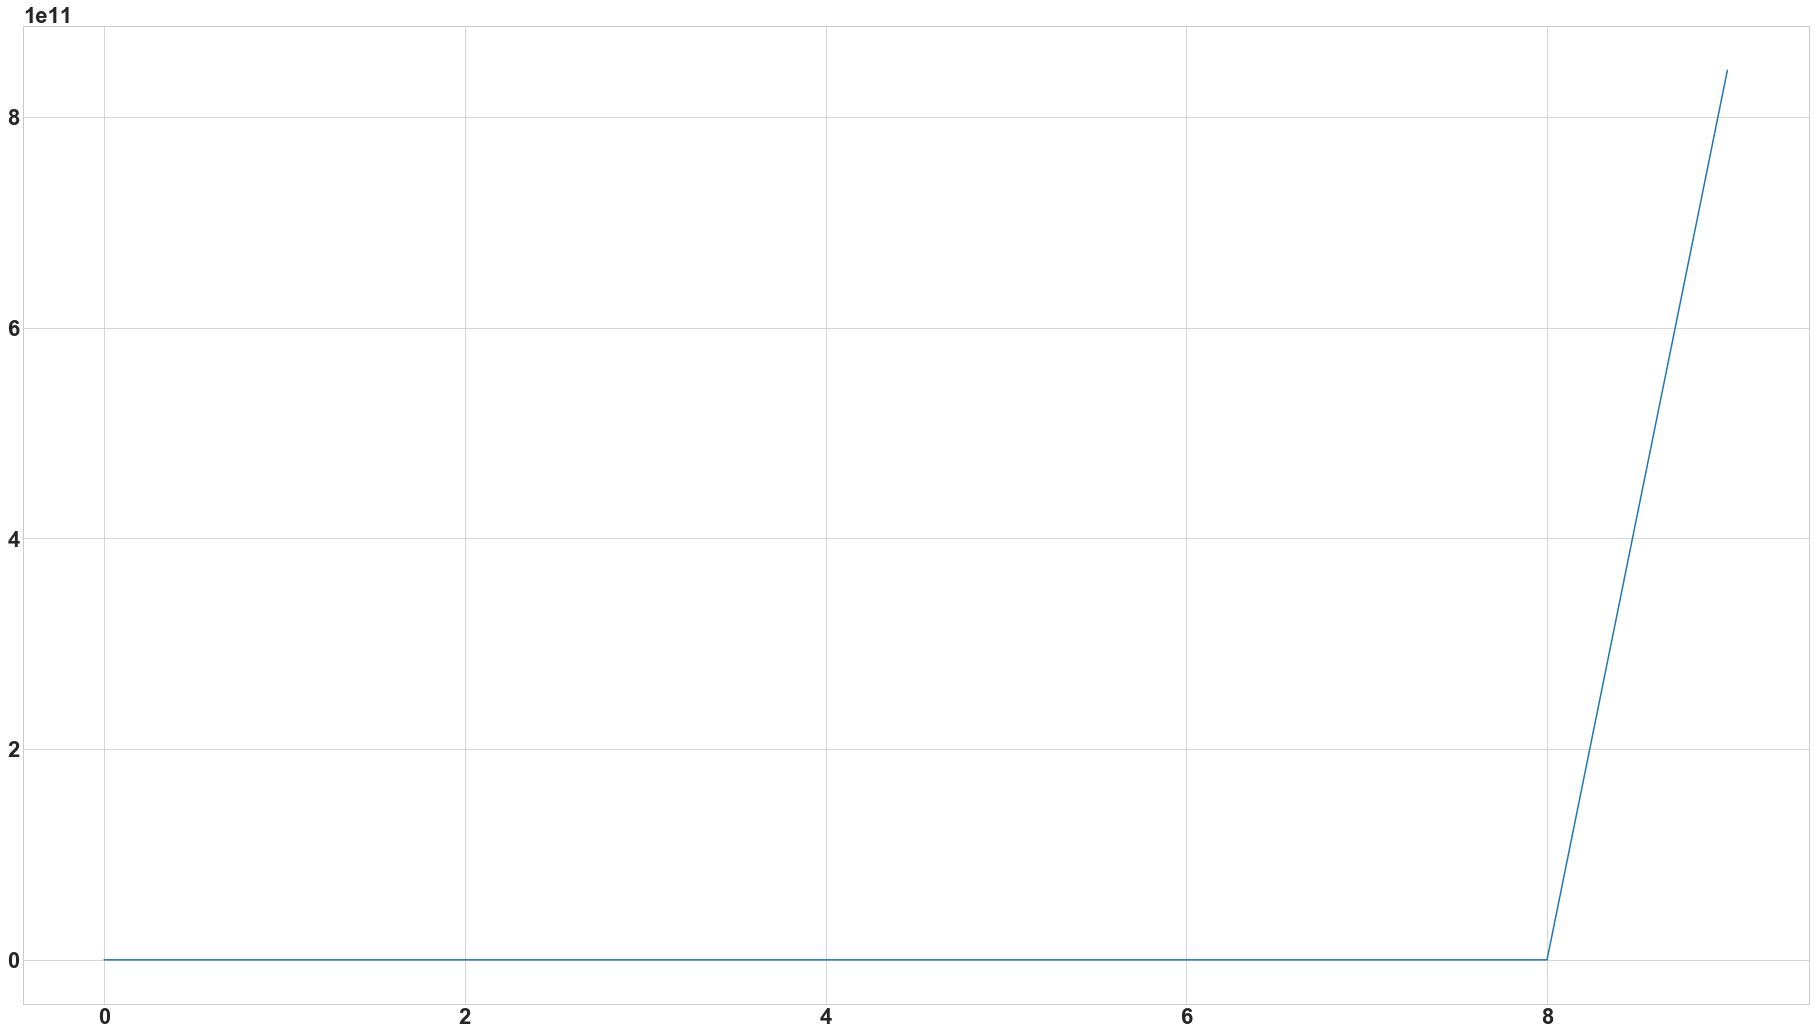

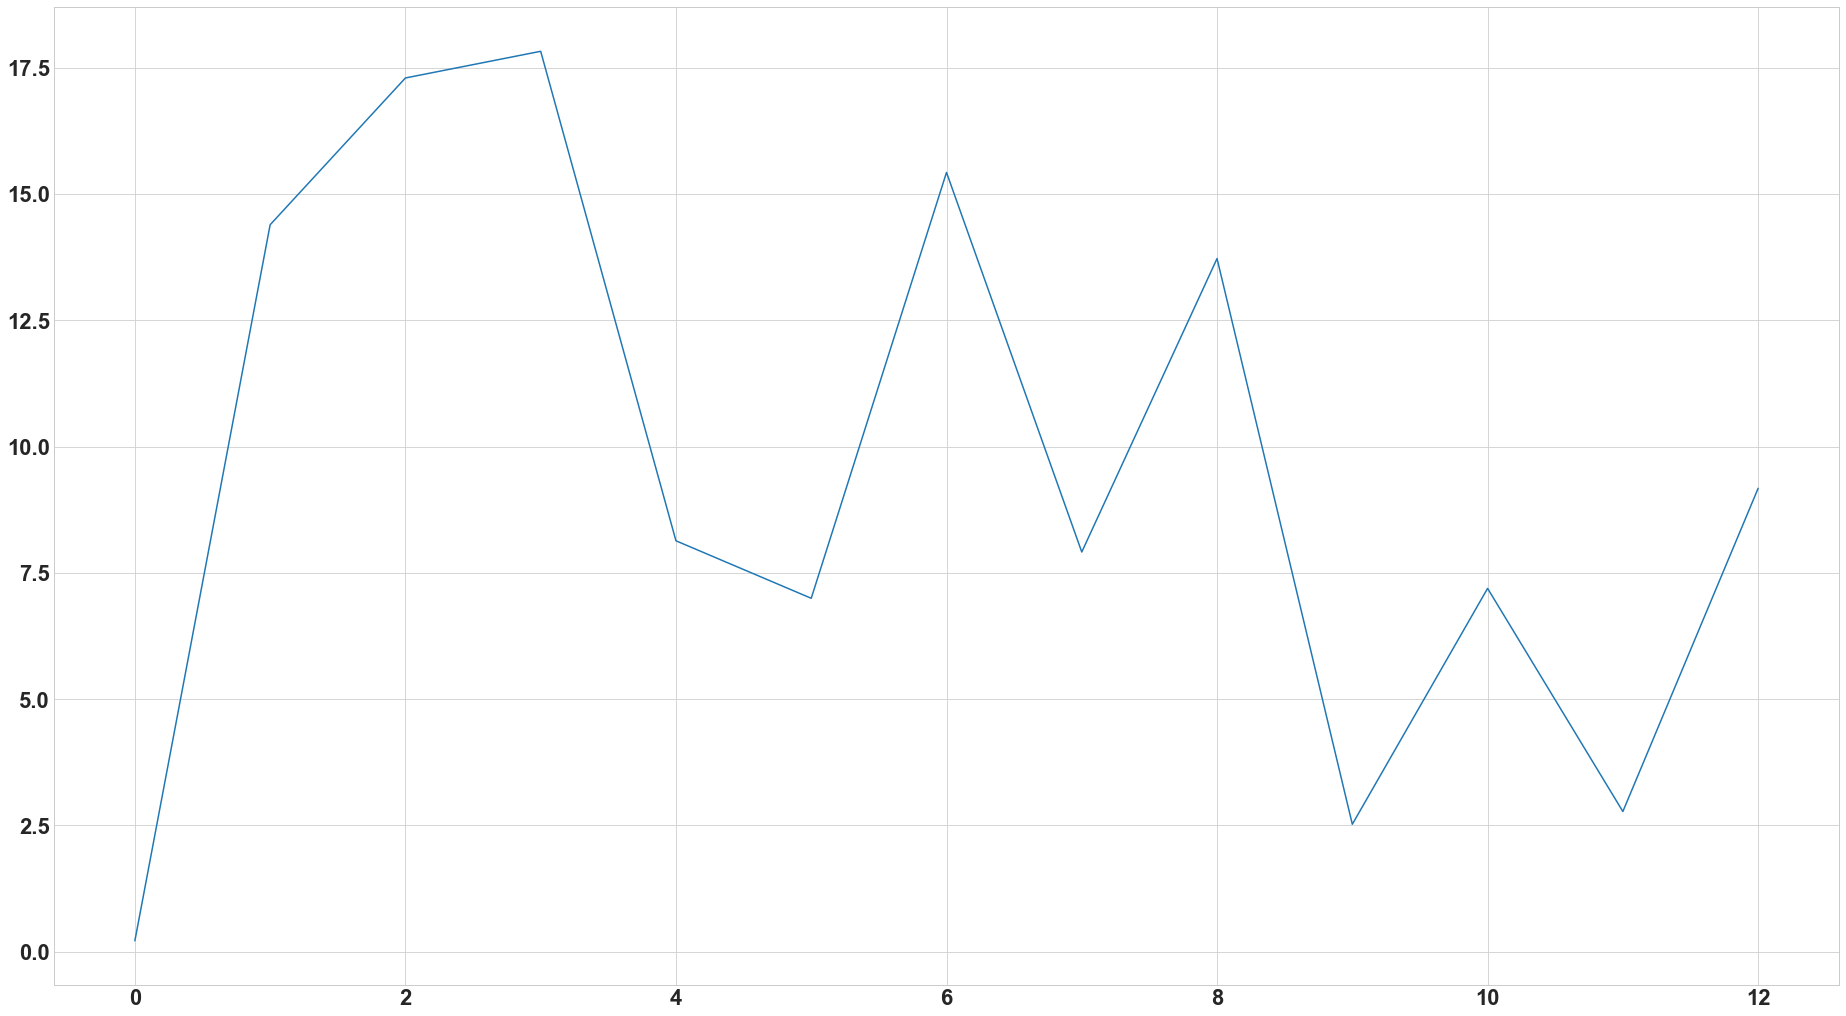

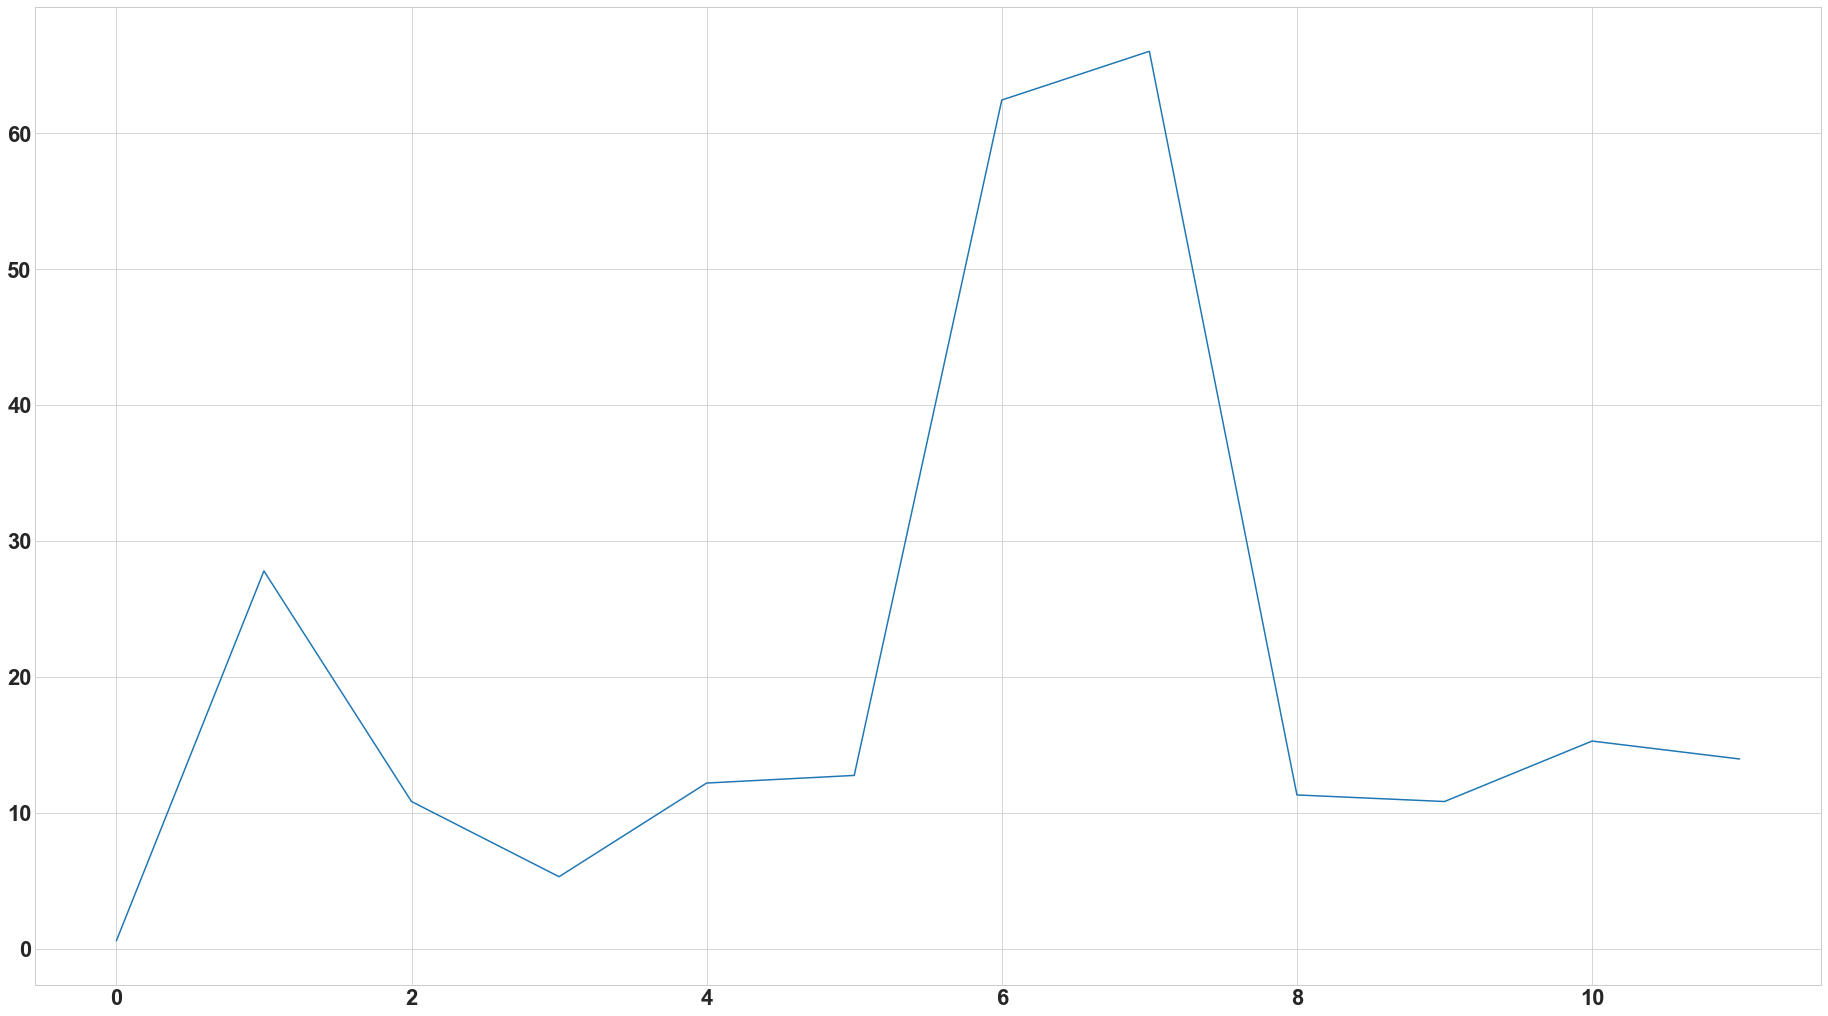

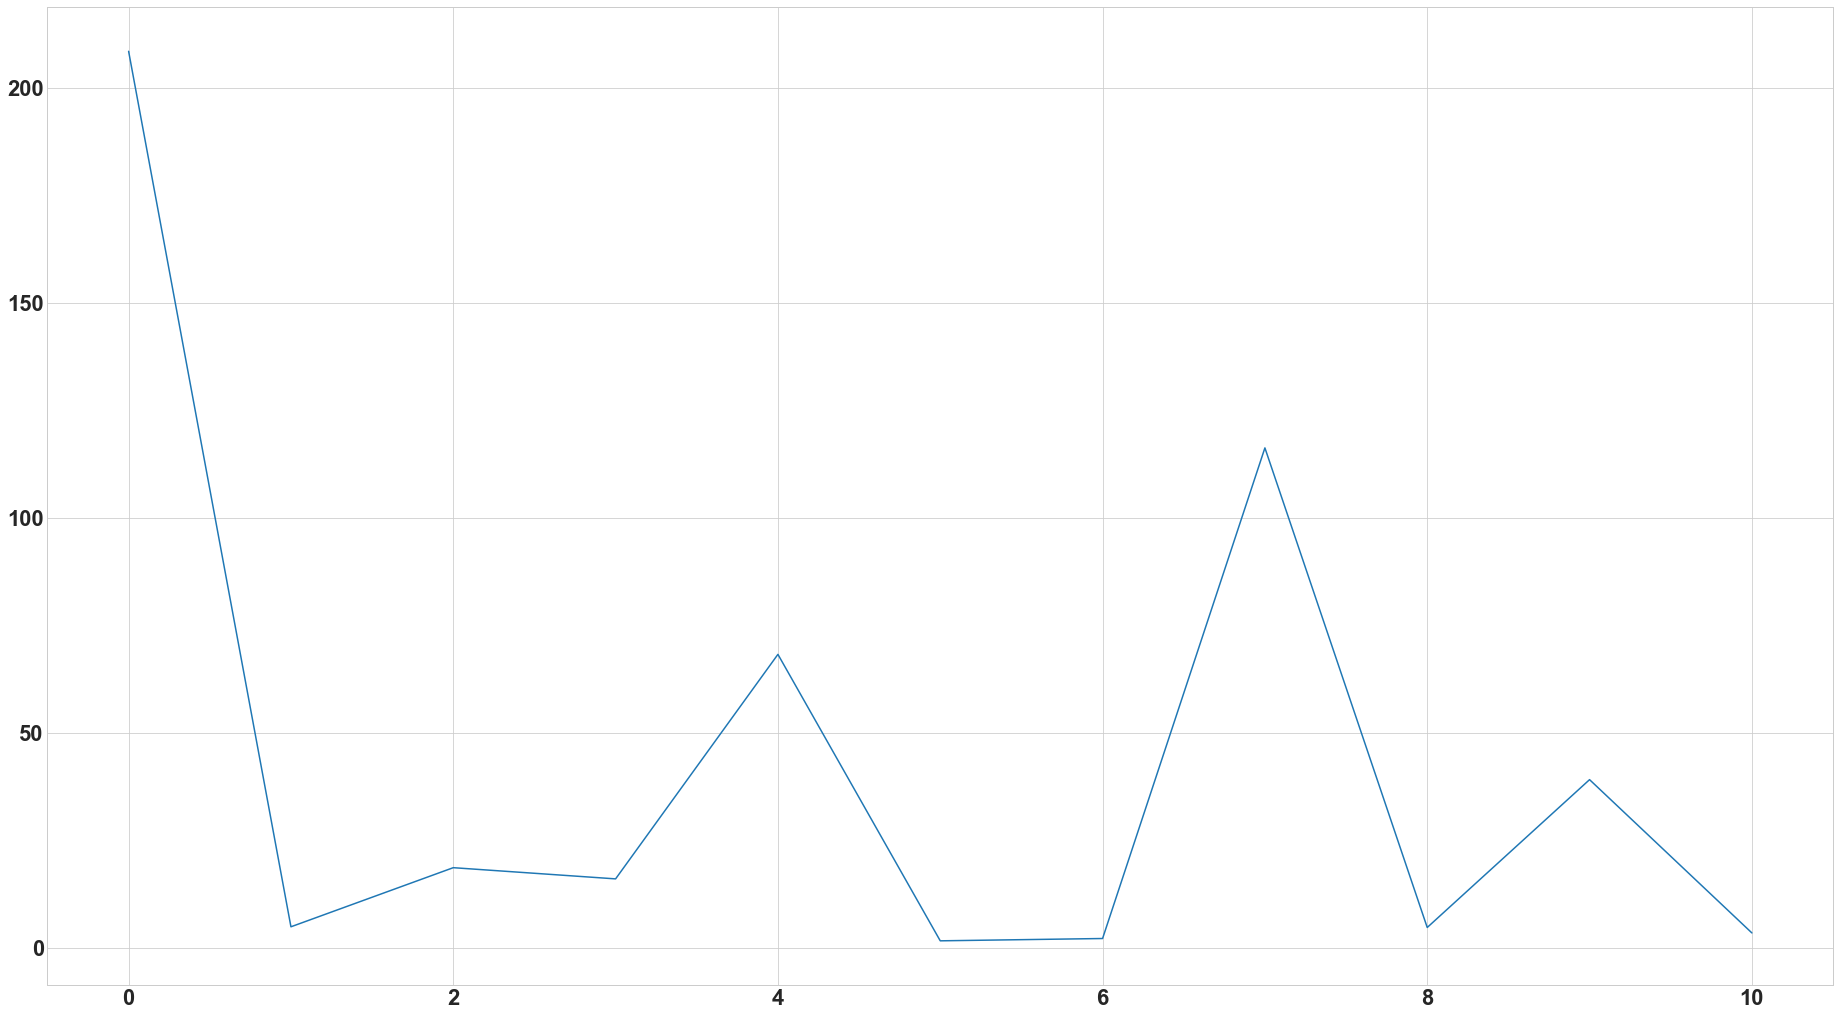

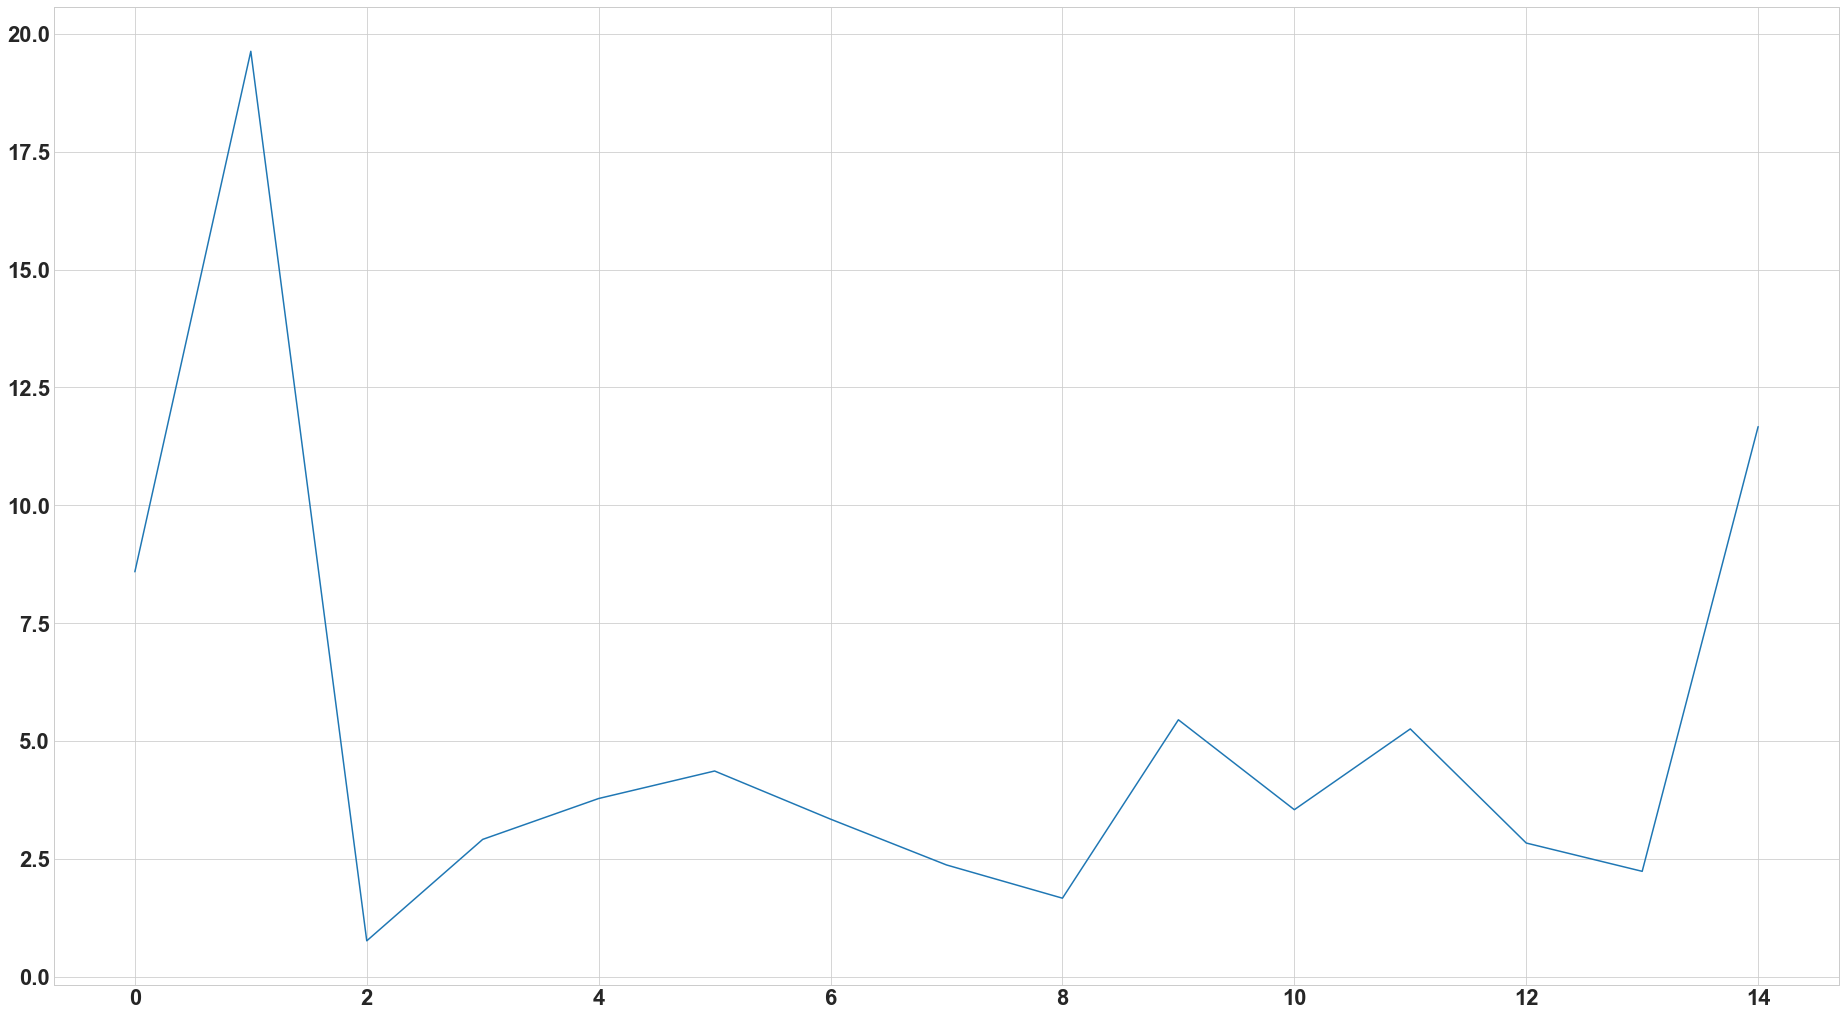

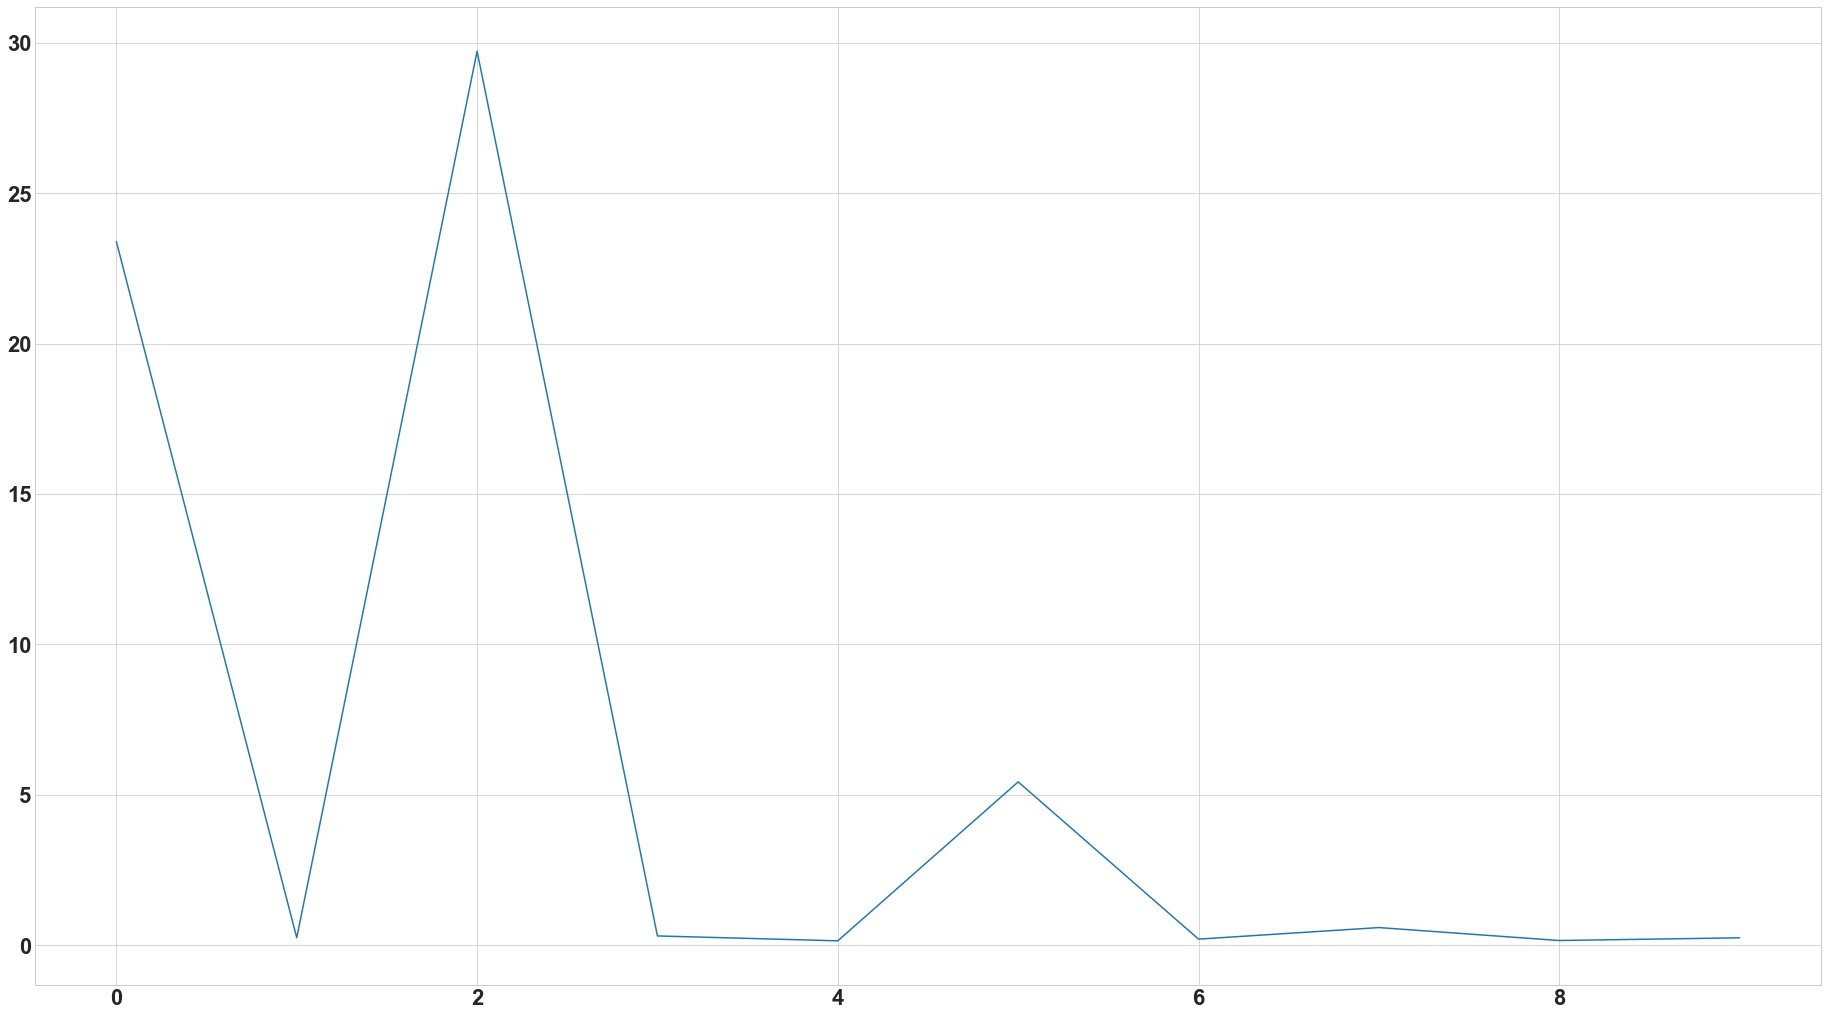

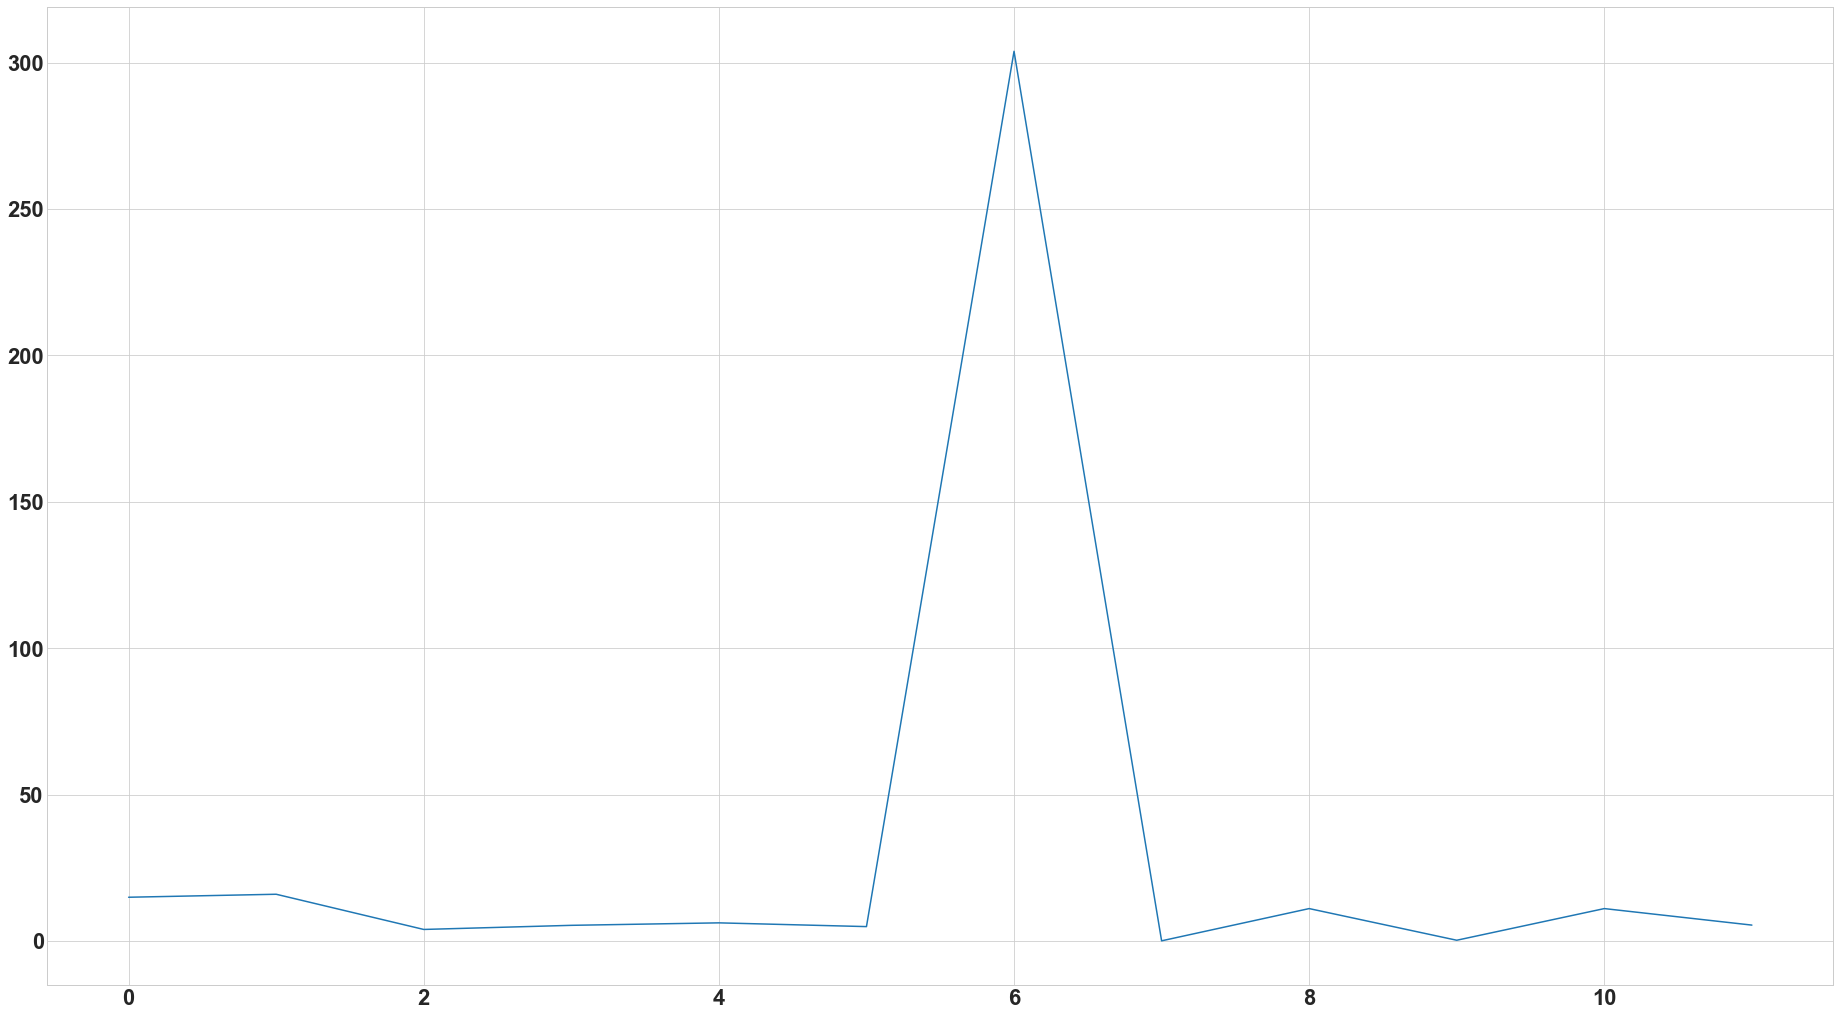

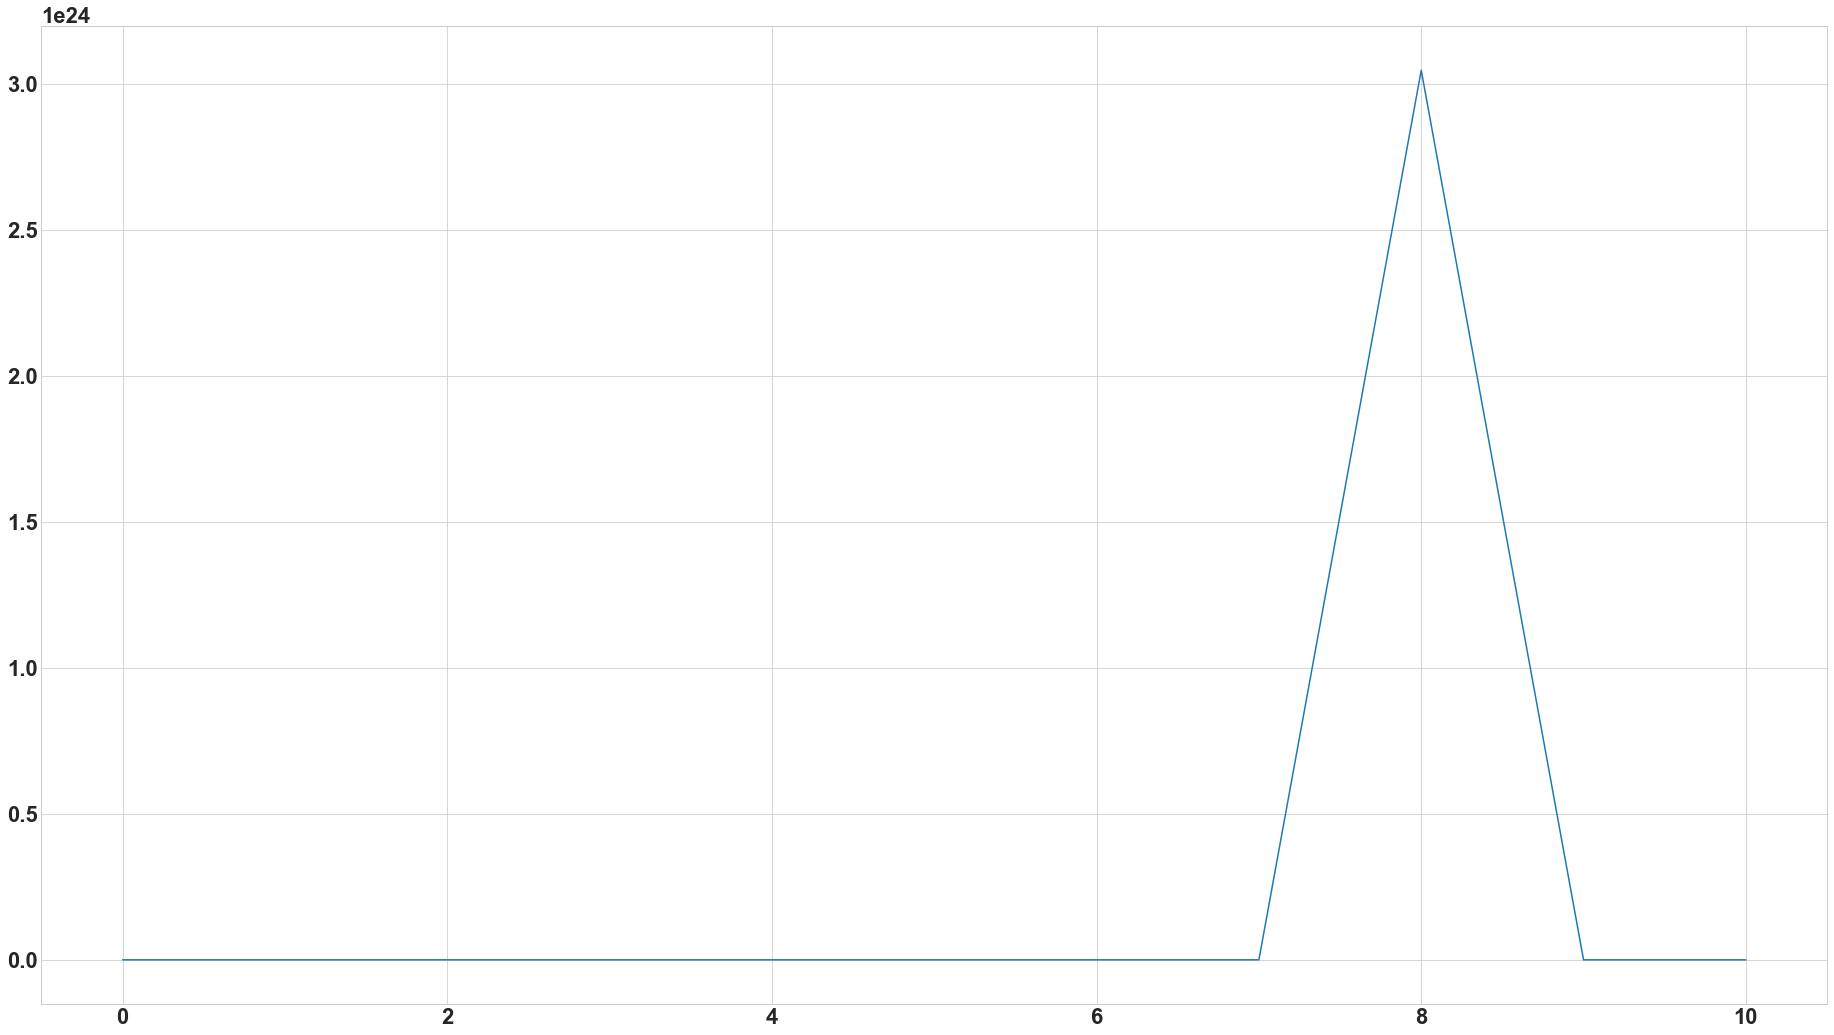

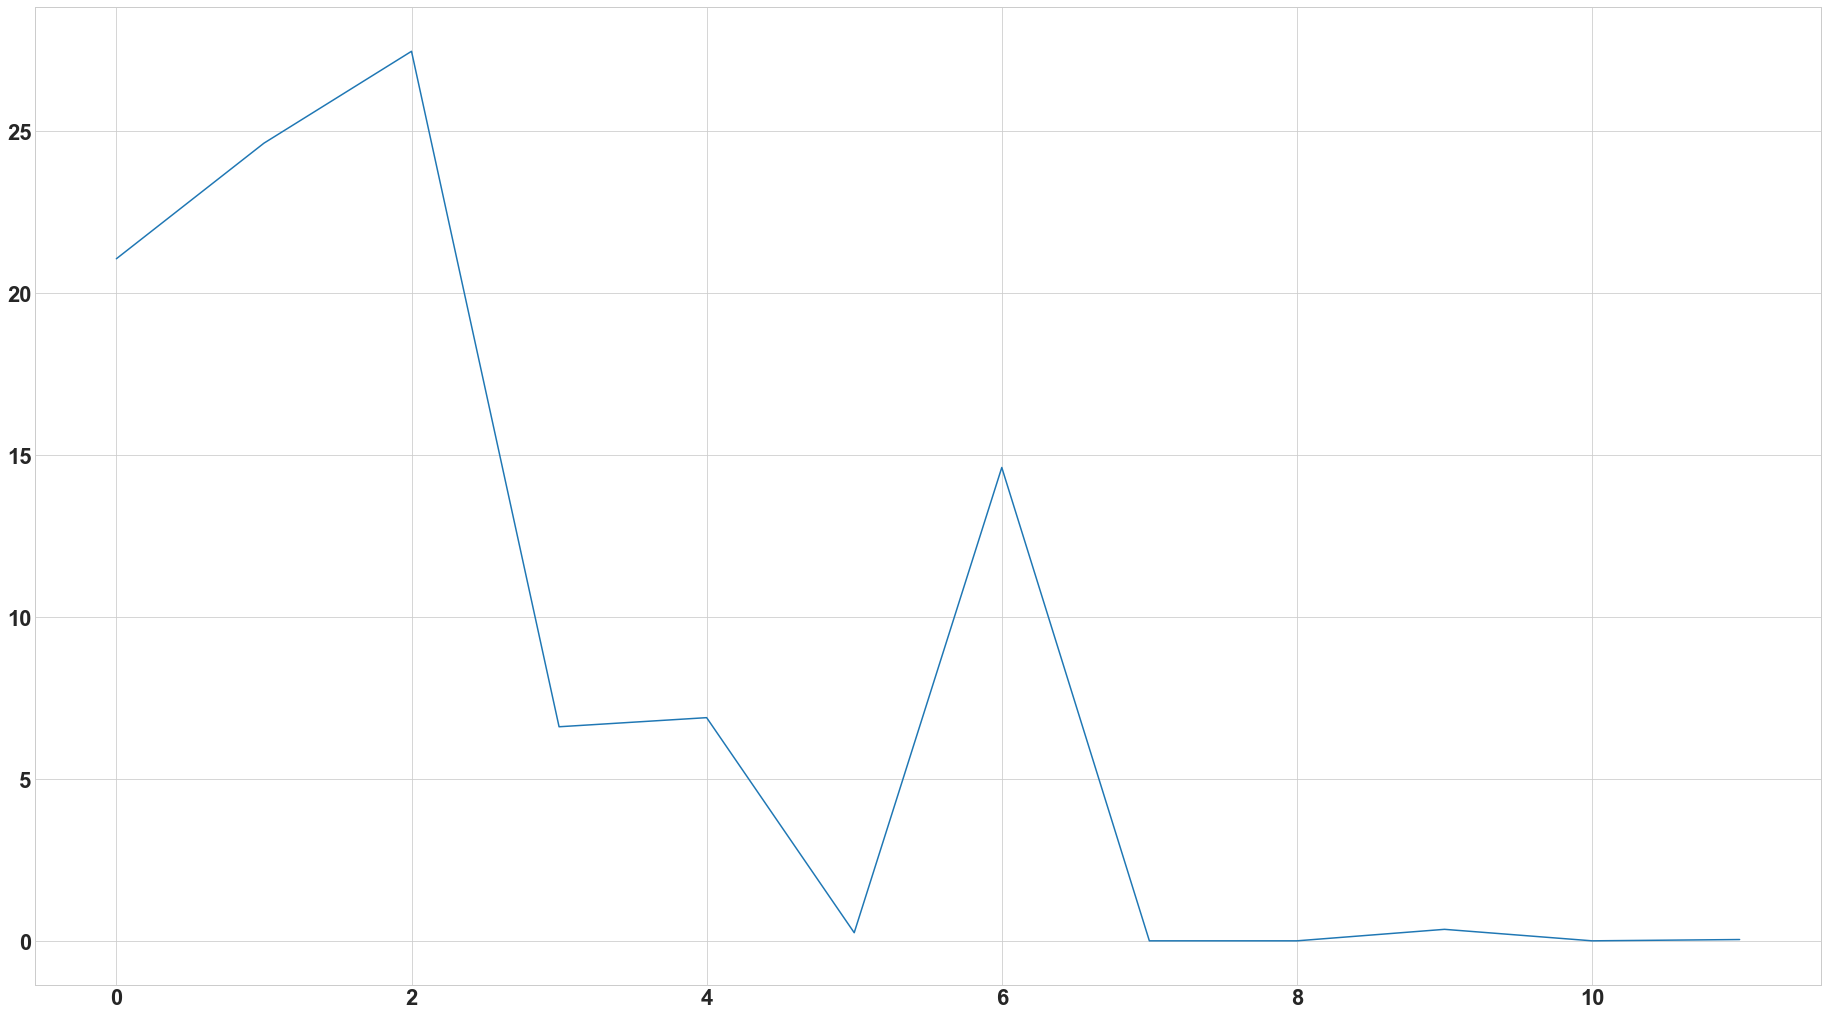

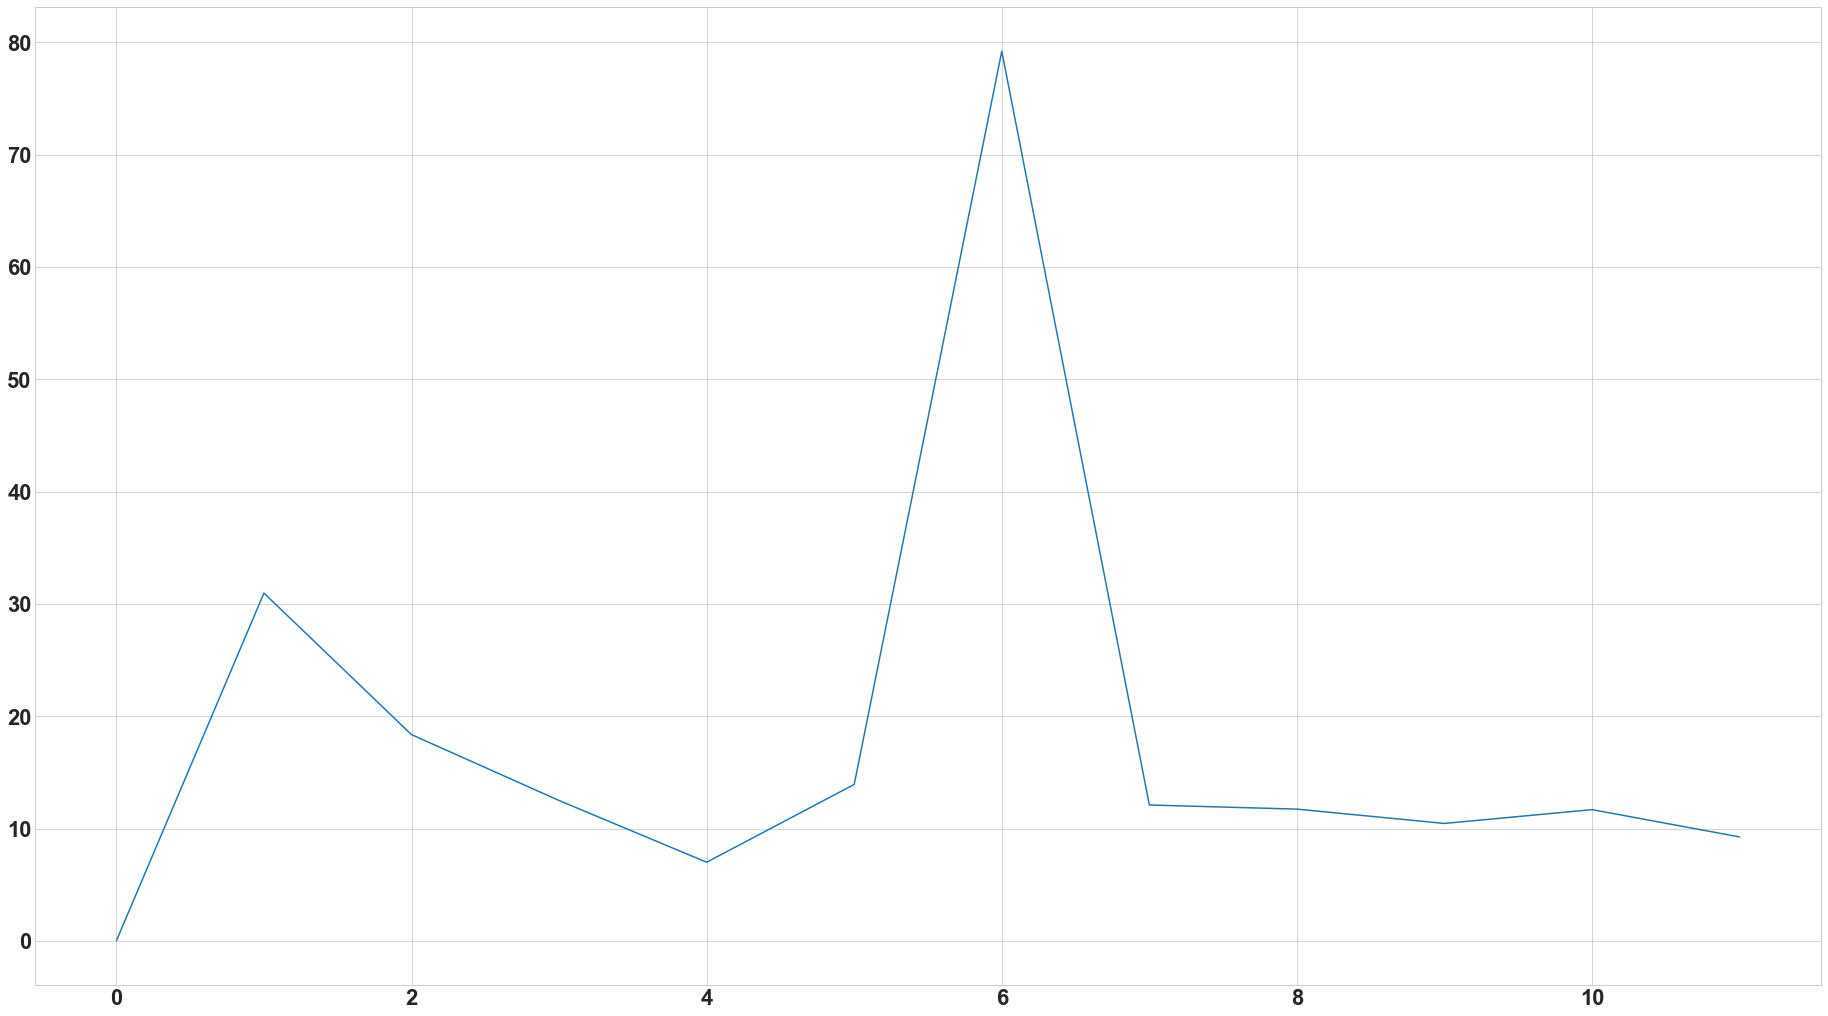

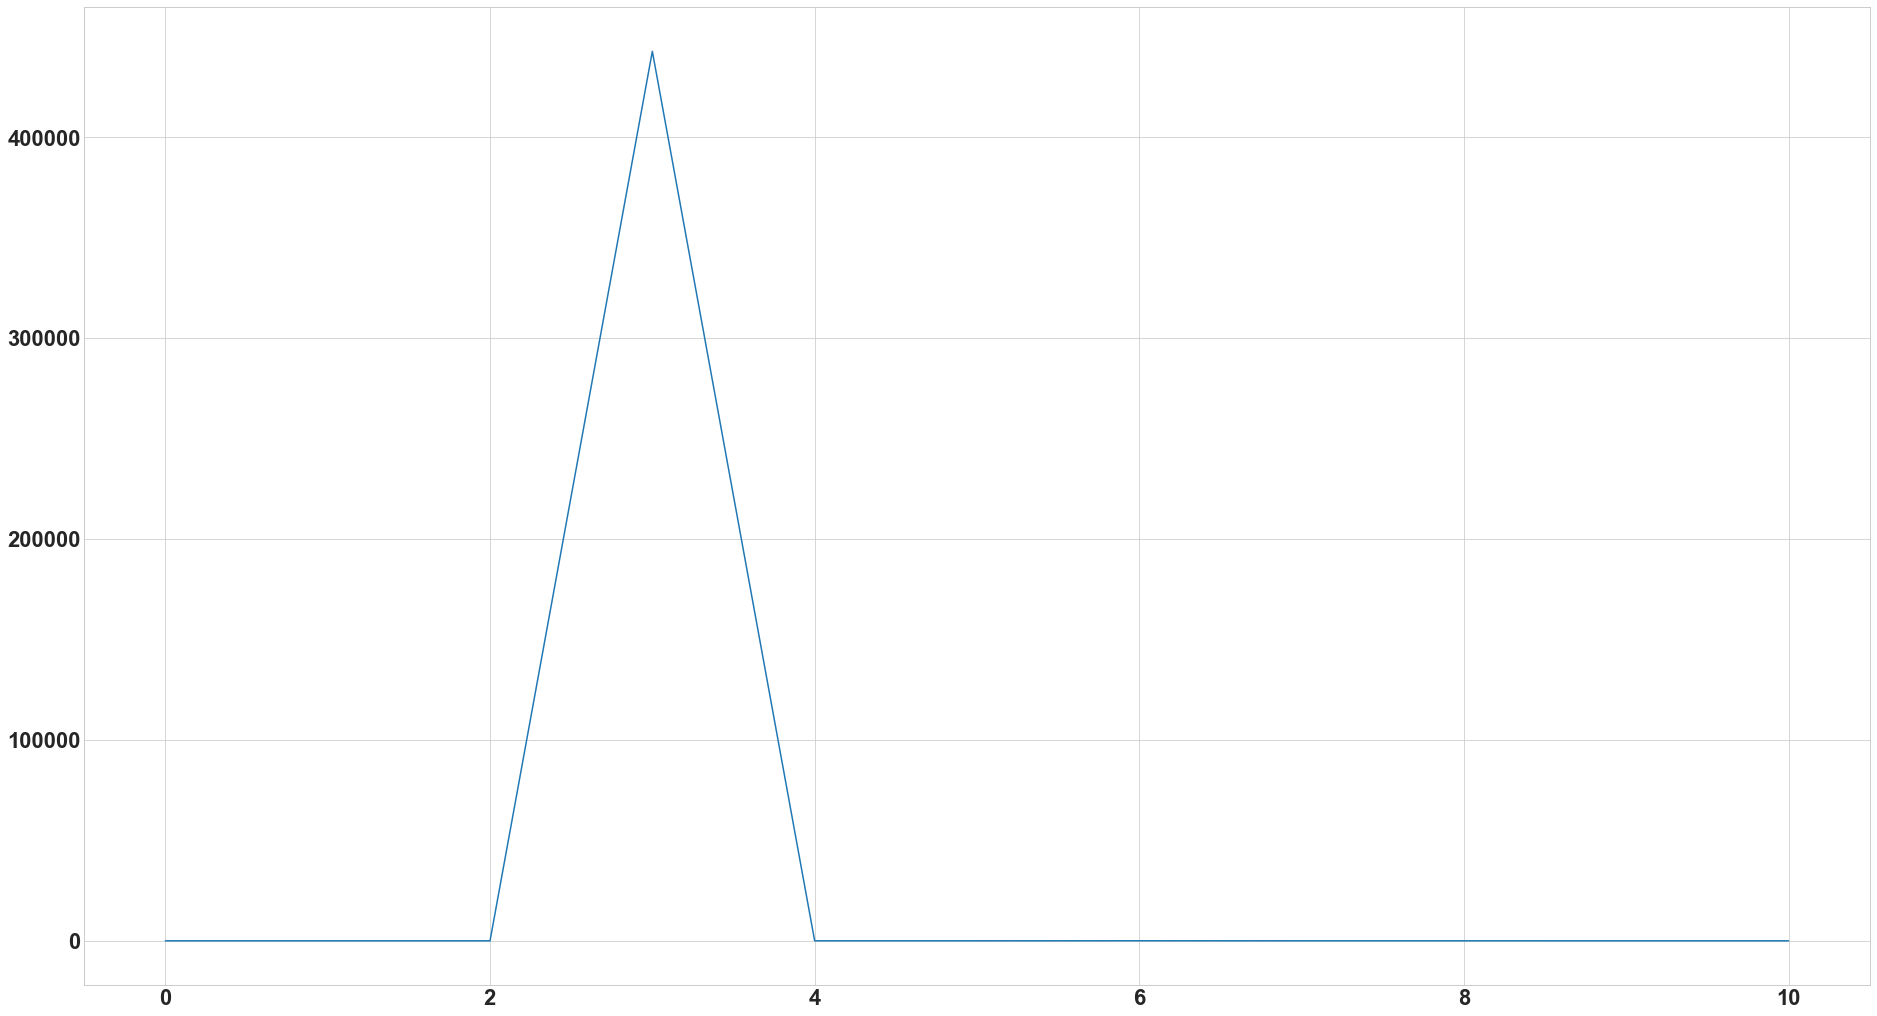

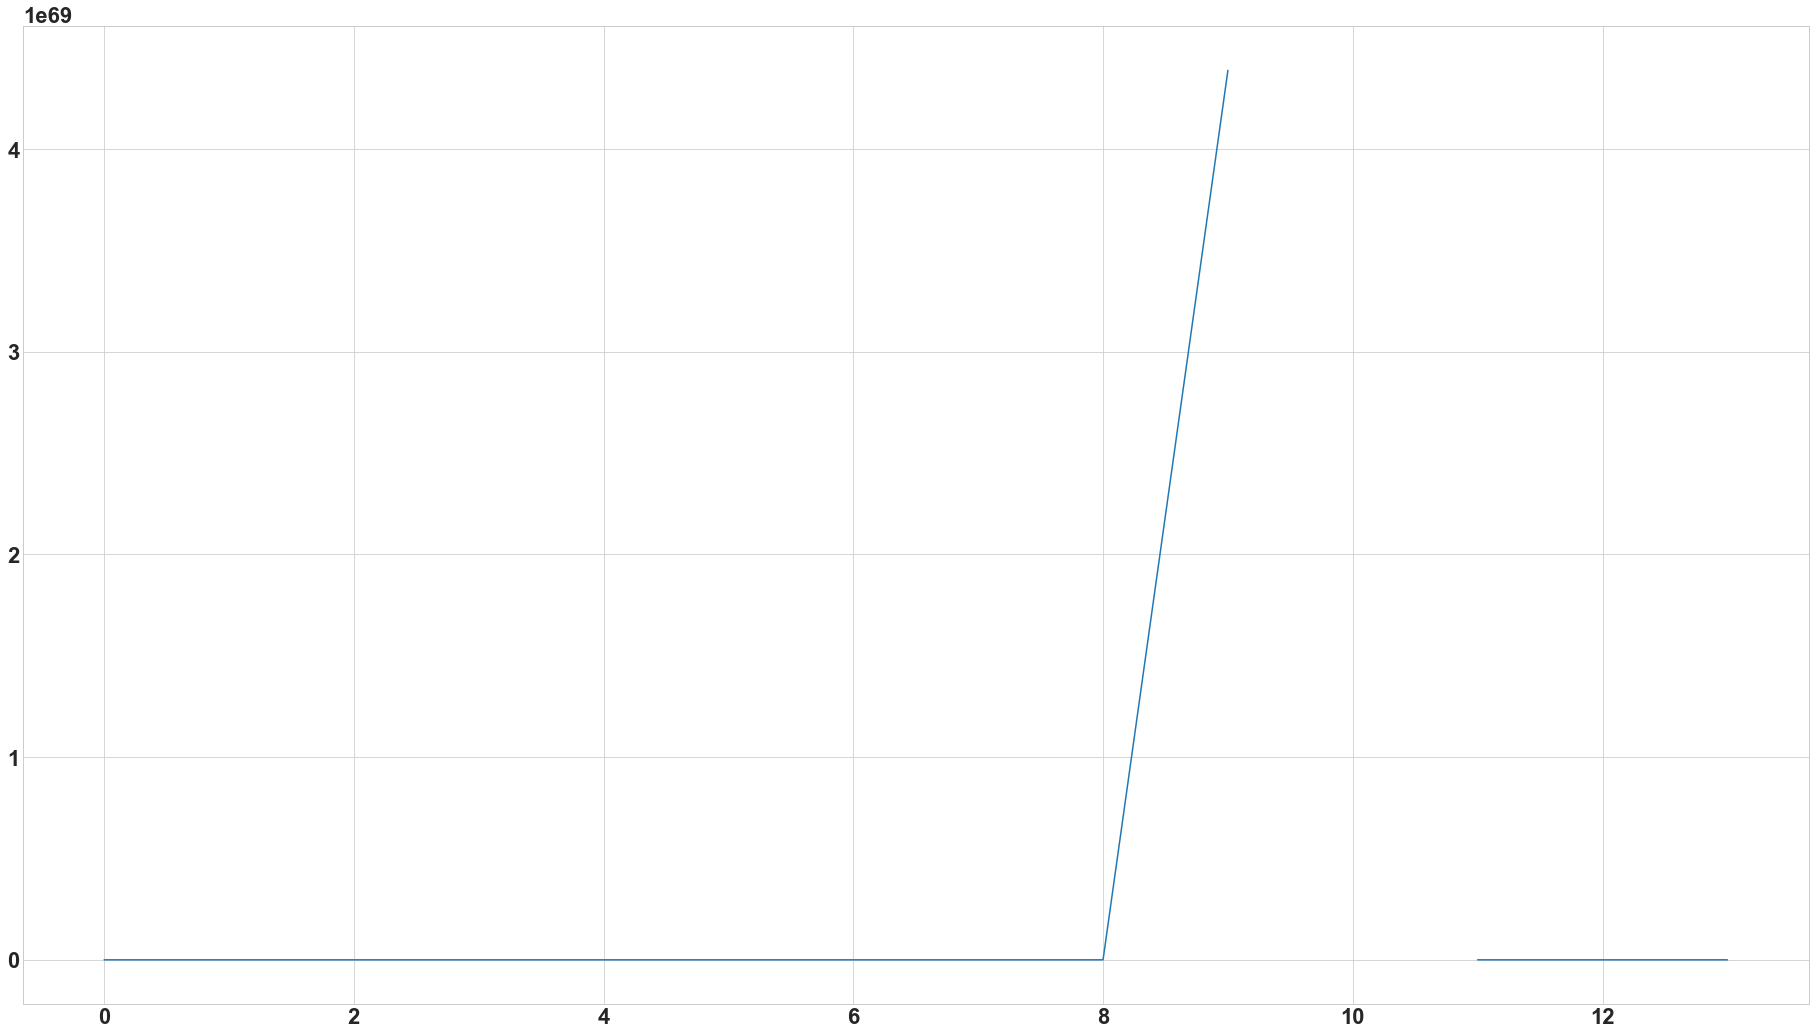

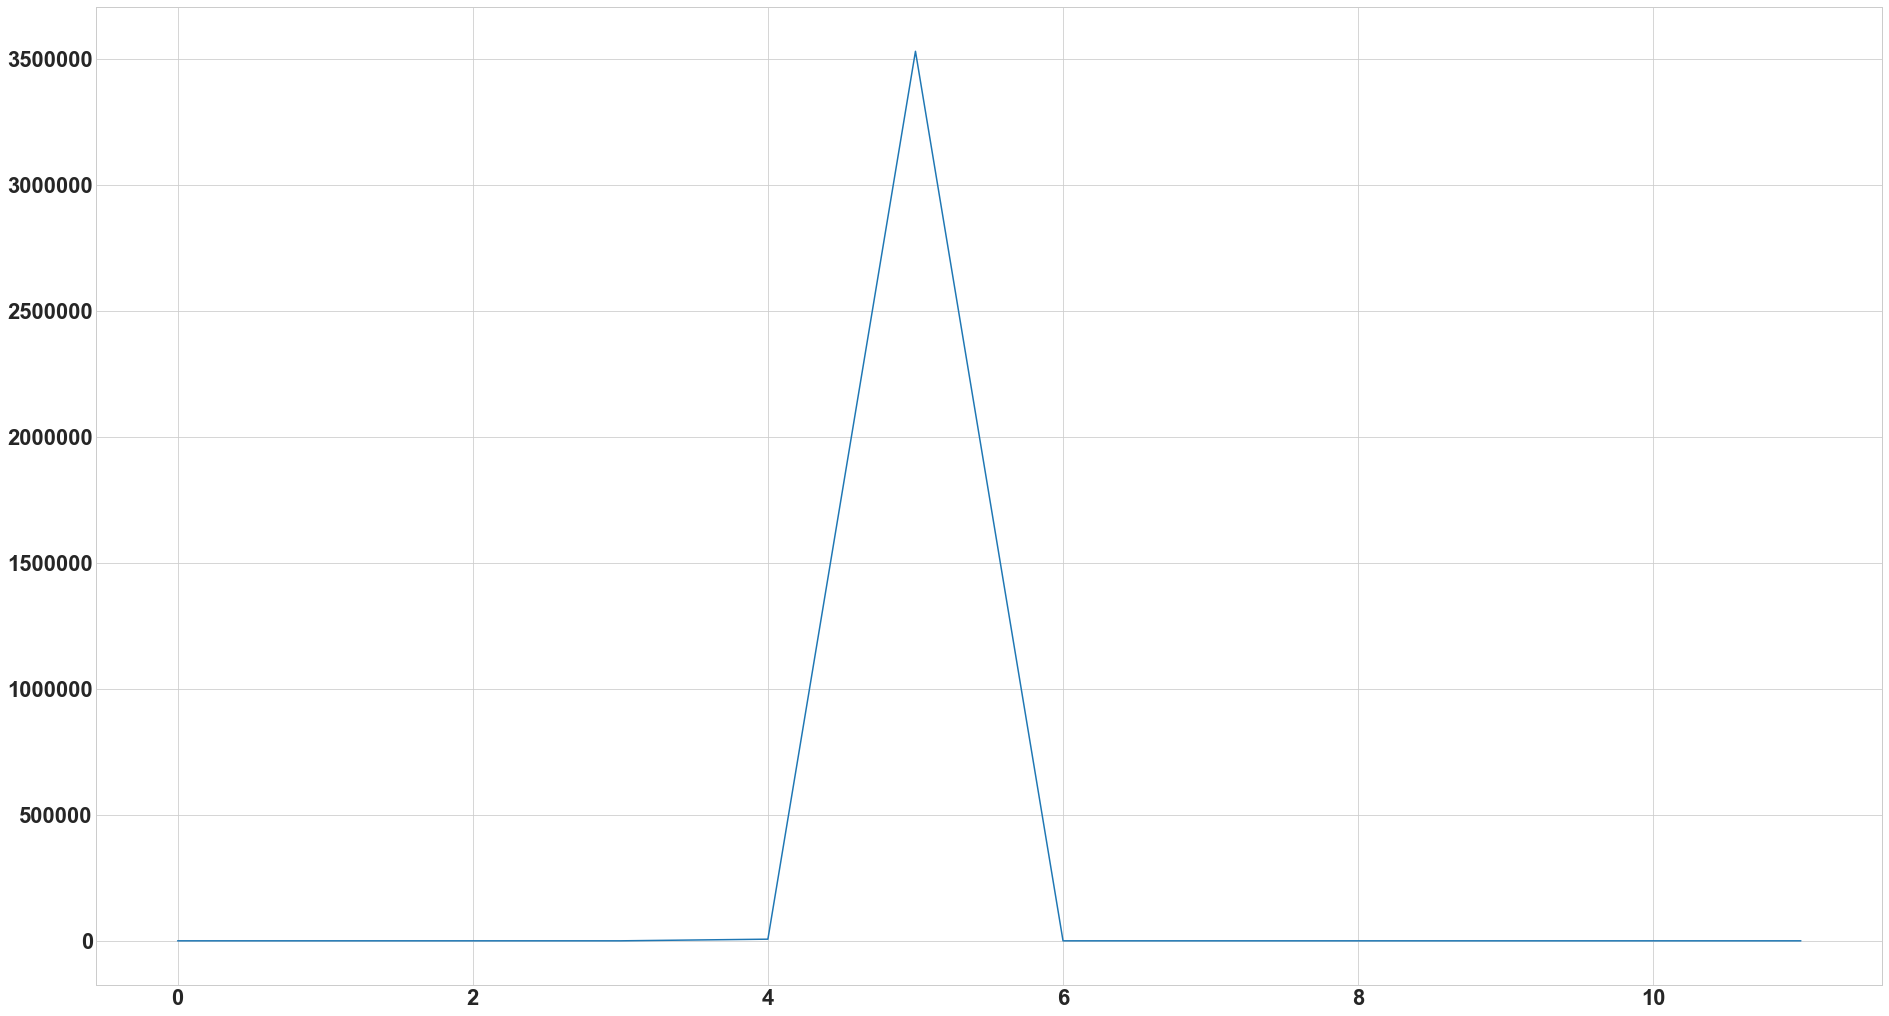

In [143]:
mttf_per_country = df.groupby(level=0)["MTTF"].agg(lambda x: list(x))

for country in mttf_per_country.index:
    ax = plt.gca()
    ax.plot(mttf_per_country[country])

    plt.show()

